In [ ]:
# Installing the dependencies... just uncomment the correct packaging tool (if you are using pip or conda)

# import sys
# ! {sys.executable} -m pip install torch
# ! {sys.executable} -m pip install librosa
# ! {sys.executable} -m pip install datasets
# ! {sys.executable} -m pip install transformers
# ! {sys.executable} -m pip install pandas
# ! {sys.executable} -m pip install matplotlib

# ! conda install pytorch
# ! conda install -c conda-forge librosa
# ! conda install -c conda-forge datasets
# ! conda install -c conda-forge transformers
# ! conda install pandas
# ! conda install -c conda-forge matplotlib

In [1]:
import torch
import librosa
from datasets import load_dataset
from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
TEST_FILE = "./data_samples.csv"

In [3]:
test = pd.read_csv(TEST_FILE, sep=',')
print(f'shape: {test.shape}')
test.head()

shape: (5, 2)


,filename,text
0,sample-000000.mp3,without the dataset the article is useless
1,sample-000001.mp3,i've got to go to him
2,sample-000002.mp3,and you know it
3,sample-000003.mp3,down below in the darkness were hundreds of pe...
4,sample-000004.mp3,hold your nose to keep the smell from disablin...


In [4]:
local_csv_dataset = load_dataset("csv", data_files=TEST_FILE)

Using custom data configuration default-06e4971bbfead705
Reusing dataset csv (C:\Users\enric\.cache\huggingface\datasets\csv\default-06e4971bbfead705\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519)
100%|██████████| 1/1 [00:00<00:00, 499.74it/s]


In [5]:
local_csv_dataset

DatasetDict({
    train: Dataset({
        features: ['filename', 'text'],
        num_rows: 5
    })
})

In [6]:
LANG_ID = "en"
MODEL_ID = "jonatasgrosman/wav2vec2-large-xlsr-53-english"

processor = Wav2Vec2Processor.from_pretrained(MODEL_ID)
model = Wav2Vec2ForCTC.from_pretrained(MODEL_ID)

In [7]:
# Preprocessing the datasets.
# We need to read the audio files as arrays

# default sample rate needed by the model
sr = 16_000 

def speech_file_to_array_fn(batch, data_dir):
    speech_array, sr = librosa.load(path=data_dir+batch["filename"], sr=16_000)
    batch["speech"] = speech_array
    batch["text"] = batch["text"].upper()
    return batch

In [8]:
TEST_DIR = './data_mp3/'
test_dataset = local_csv_dataset["train"].map(
    speech_file_to_array_fn, 
    fn_kwargs={
        'data_dir': TEST_DIR,
        }
    )

Loading cached processed dataset at C:\Users\enric\.cache\huggingface\datasets\csv\default-06e4971bbfead705\0.0.0\433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519\cache-fbbcc218a5829b4c.arrow


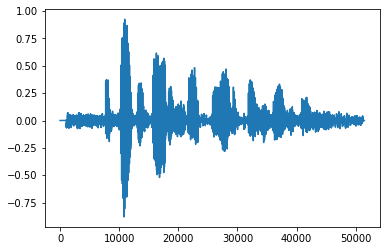

In [9]:
# Example plot for visualisation of the first speech array loaded in dataset

plt.plot(test_dataset[0]['speech'])
plt.show()

In [10]:
# Inference

inputs = processor(test_dataset["speech"], sampling_rate=16_000, return_tensors="pt", padding=True)

with torch.no_grad():
    logits = model(inputs.input_values, attention_mask=inputs.attention_mask).logits

predicted_ids = torch.argmax(logits, dim=-1)
predicted_sentences = processor.batch_decode(predicted_ids)

# for i, predicted_sentence in enumerate(predicted_sentences):
#     print("-" * 100)
#     print("Reference:", test_dataset[i]["text"])
#     print("Prediction:", predicted_sentence)

example_prediction = predicted_sentences[0]
print("Reference:", test_dataset[0]["text"])
print("Prediction:", example_prediction)

Reference: WITHOUT THE DATASET THE ARTICLE IS USELESS
Prediction: without the dataset the article is useless


In [11]:
# Getting time stamps for each word:
# referenced and adapted from https://github.com/huggingface/transformers/issues/11307

from itertools import groupby

words = [w for w in example_prediction.split(' ') if len(w) > 0]
predicted_ids_list = predicted_ids[0].tolist()
duration_sec = inputs['input_values'][0].size(dim=0) / sr

ids_w_time = [(i / len(predicted_ids_list) * duration_sec, _id) for i, _id in enumerate(predicted_ids_list)]
# remove entries which are just "padding" (i.e. no characers are recognized)
ids_w_time = [i for i in ids_w_time if i[1] != processor.tokenizer.pad_token_id]
# now split the ids into groups of ids where each group represents a word
split_ids_w_time = [list(group) for k, group
                    in groupby(ids_w_time, lambda x: x[1] == processor.tokenizer.word_delimiter_token_id)
                    if not k]

assert len(split_ids_w_time) == len(words)  # make sure that there are the same number of id-groups as words. Otherwise something is wrong

word_start_times = []
word_end_times = []
for cur_ids_w_time, cur_word in zip(split_ids_w_time, words):
    _times = [_time for _time, _id in cur_ids_w_time]
    word_start_times.append(min(_times))
    word_end_times.append(max(_times))

In [12]:
for i, word in enumerate(words):
    print(f"{word} (start: {word_start_times[i]}, end: {word_end_times[i]})")

without (start: 0.4614375, end: 0.7423125)
the (start: 0.8025, end: 0.8827499999999999)
dataset (start: 0.9429375, end: 1.4645625)
the (start: 1.564875, end: 1.6250624999999999)
article (start: 1.725375, end: 2.00625)
is (start: 2.1065625, end: 2.1466874999999996)
useless (start: 2.32725, end: 2.7285)
